In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans
from tqdm.auto import trange, tqdm
import warnings
warnings.filterwarnings('ignore')

import datetime
import re

In [37]:
df = pd.read_csv('./topline_metrics.csv')

**After inspecting the dataset, several duplicates are found. Therefore, we have to drop duplicates before precessing.**

In [38]:
df.drop_duplicates(subset=None, keep='first', inplace=True)

In [39]:
df.head(3)

,Date,Date.1,Platform,Country,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
0,2018-03-15,2018-03-15,Android(All),Kazakhstan(哈萨克斯坦),628852.81,15498.31,43429.11,3428.09,17.58,1.3,2.3,4527.01,79.12,58.18
1,2018-03-15,2018-03-15,ALL,United States(美国),633293.54,19939.05,43429.11,3428.09,17.58,1.3,2.3,4527.01,75.65,58.87
3,2018-03-15,2018-03-15,ALL,Guatemala(危地马拉),628976.03,15621.54,43429.11,3428.09,17.58,1.3,2.3,4527.01,74.62,46.21


In [79]:
df.describe()

,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
count,3.872870e+05,3.872870e+05,3.872870e+05,387287.000000,387287.000000,387287.000000,387287.000000,387287.000000,387287.000000,387287.000000
mean,7.405406e+05,1.814749e+04,5.090994e+04,3958.958757,31.588136,1.415199,2.900178,5092.220355,39.803183,122.565397
std,6.836457e+05,1.706030e+04,4.659028e+04,3653.633879,23.878126,1.344340,2.579061,4656.117813,24.101990,43.372413
min,6.286478e+05,1.529217e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,12.210000,-9.990000
25%,6.288102e+05,1.529677e+04,4.342911e+04,3428.090000,17.580000,1.300000,2.300000,4527.010000,28.660000,98.840000
50%,6.314659e+05,1.537393e+04,4.352009e+04,3433.850000,28.070000,1.320000,2.560000,4532.770000,39.440000,118.180000
75%,6.574378e+05,1.617778e+04,4.466252e+04,3522.530000,36.070000,1.390000,3.000000,4611.080000,48.915000,139.370000
max,2.677675e+07,2.141935e+06,4.387412e+06,434846.580000,1744.870000,444.240000,232.630000,819825.280000,3912.090000,1390.060000


## Clustering with Kmeans

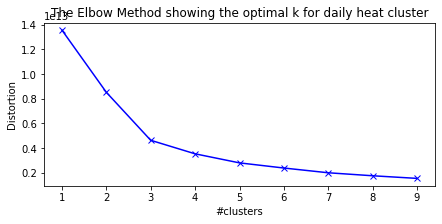

In [49]:
dff = df[['Trans','Cash Flow']]
distortions = []
K = range(1,10)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(dff)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(7,3))
plt.plot(K,distortions,'bx-')
plt.xticks(K,K)
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k for daily heat cluster')
plt.xlabel('#clusters')
plt.show()

In [ ]:
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(dff)

Plot the clustering result

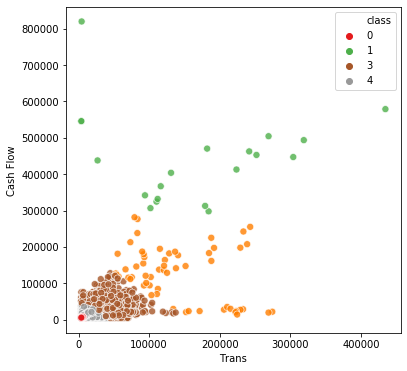

In [80]:
dff['class'] = kmeanModel.labels_

plt.figure(figsize=(6,6))
sns.scatterplot(x="Trans", y="Cash Flow", hue="class", data=dff, palette="Set1", s=50, alpha=0.8)

## Anomaly Detection

In [6]:
def sigma3_detect_outliers(df, col):
    return df[(df[col]>df[col].mean()+3*df[col].std())|(df[col]<df[col].mean()-3*df[col].std())]

def iqr_detect_outliers(df, col, n=3):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col]>Q3 + n*IQR)|(df[col]<Q1 - n*IQR)]

# sigma3_detect_outliers(df, 'Trans')

def delete_outliers(df, col, inplace):
    return df.drop(sigma3_detect_outliers(df, col).index, inplace=inplace)

#### Delete Anomaly Data

In [ ]:
# delete_outliers(df, 'Trans', True)
for i in ['TRU', 'DAU', 'Items', 'Trans',
       'Items Per Trans', 'Items per DAU', 'Conversion', 'Cash Flow',
       'Return Customer', 'Time Spend Per Day(seconds)']:
    delete_outliers(df, i, True)

In [7]:
df.describe()

,TRU,DAU,Items,Trans,Items Per Trans,Items per DAU,Conversion,Cash Flow,Return Customer,Time Spend Per Day(seconds)
count,3.493140e+05,349314.000000,349314.000000,349314.000000,349314.000000,349314.000000,349314.000000,349314.000000,349314.000000,349314.000000
mean,6.638456e+05,16337.125918,45513.375181,3553.775732,29.842512,1.371523,2.750194,4684.730262,38.050033,119.466779
std,9.673519e+04,2760.331879,6430.405632,324.947998,13.176996,0.133897,0.610177,495.803035,17.486245,34.911970
min,6.286478e+05,15292.170000,43429.110000,3428.090000,17.580000,1.300000,2.300000,4527.010000,12.210000,-8.380000
25%,6.288298e+05,15297.920000,43429.110000,3428.090000,17.580000,1.300000,2.300000,4527.010000,28.660000,98.150000
50%,6.314331e+05,15373.930000,43507.420000,3433.850000,28.020000,1.320000,2.550000,4531.620000,39.220000,117.150000
75%,6.520008e+05,16020.000000,44396.490000,3502.950000,35.610000,1.380000,2.950000,4593.810000,48.190000,137.650000
max,2.655406e+06,44528.950000,146335.400000,6043.480000,103.940000,2.940000,7.050000,10606.540000,112.970000,252.240000


## Correlation Analysis

#### Feature Engineering
Here, I create four new features by hand. 

In [8]:
df['bought_items']=df['Trans']*df['Items Per Trans']
df['dau_items']=df['Items per DAU']*df['DAU']
df['dead_items']=df['Items']-df['dau_items']
df['free_items']=df['Items']-df['bought_items']

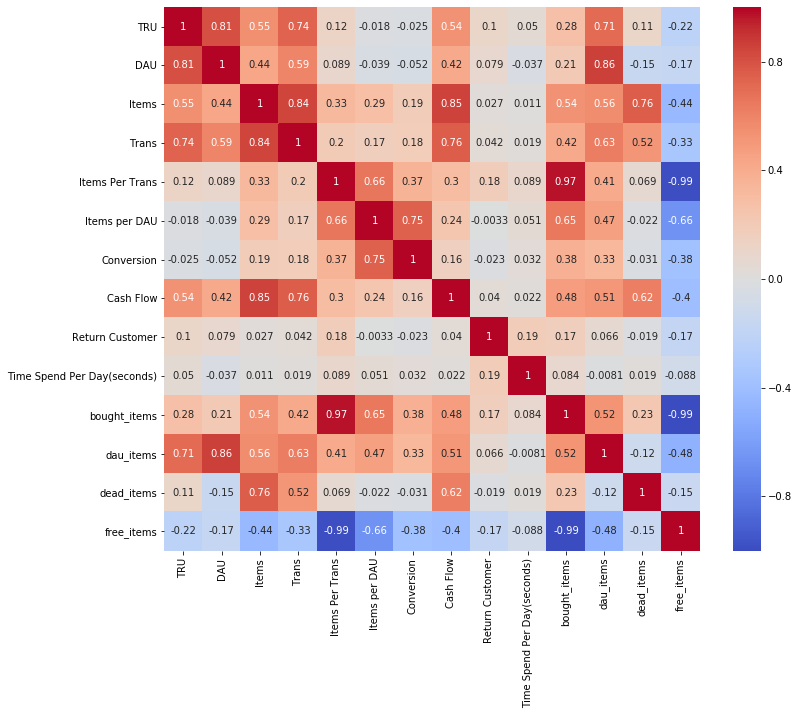

In [9]:
cor = df.corr()
import seaborn as sns
plt.figure(figsize=(12,10))
ax =sns.heatmap(df.corr(),annot=True,cmap='coolwarm',vmin=-1, vmax=1, center= 0)

#### Whether Use Date or Platform

I tried to do prediction with `'Date'` and `'Platform'`. Considering these two features are categorical data, we transform them into dummy variables first with functions showing as below. 

**However**, using these two features will make prediction harder. So, in the next experiment (Prediction with Regression), we drop these two features.

In [10]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)
        
# add_datepart(df, 'Date')

def encode_platform(x):
    if x=='ALL':
        o = 2
    elif x=='Android(All)':
        o = 1
    elif x=='IOS(All)':
        o = 0
    else:
        raise ValueError
    return o
        
# df['Platform']=df['Platform'].map(encode_platform)

In [13]:
# df = df[df['Platform']!=2]

## Prediction with Regression

#### Drop Unnecessary Features

In [14]:
X = df.drop(['Platform', 'Trans','Country','Date.1','Date', 'Return Customer', 'Time Spend Per Day(seconds)'],axis=1)
y= df['Trans']

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import numpy as np

#### Data Standardization and Splitting

In [16]:
sc=StandardScaler()
X=sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

#### Model Training

Here I use `RandomForestRegressor` for simplicity. Other regression models can also be used.

In [17]:
regr = RandomForestRegressor(n_estimators=100)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

#### Mean Absolute Error

In [32]:
mean_absolute_error(regr.predict(X_test), y_test)

0.8349380665540133

#### Mean Relative Error

In [31]:
mean_absolute_error(regr.predict(X_test), y_test)/y_test.abs().mean()

0.00023495600427419052